Merged DataFrame:
        Image Index  Bbox [x   y   w  h]  Atelectasis_x  Cardiomegaly_x  \
0  00000001_000.png      NaN NaN NaN NaN            NaN             NaN   
1  00000001_001.png      NaN NaN NaN NaN            NaN             NaN   
2  00000001_002.png      NaN NaN NaN NaN            NaN             NaN   
3  00000002_000.png      NaN NaN NaN NaN            NaN             NaN   
4  00000003_000.png      NaN NaN NaN NaN            NaN             NaN   

   Effusion_x  Infiltrate  Mass_x  ...  No Finding  Nodule_y  \
0         NaN         NaN     NaN  ...           0         0   
1         NaN         NaN     NaN  ...           0         0   
2         NaN         NaN     NaN  ...           0         0   
3         NaN         NaN     NaN  ...           1         0   
4         NaN         NaN     NaN  ...           0         0   

   Pleural_Thickening  Pneumonia_y  Pneumothorax_y  Patient Gender_F  \
0                   0            0               0                 0   
1 

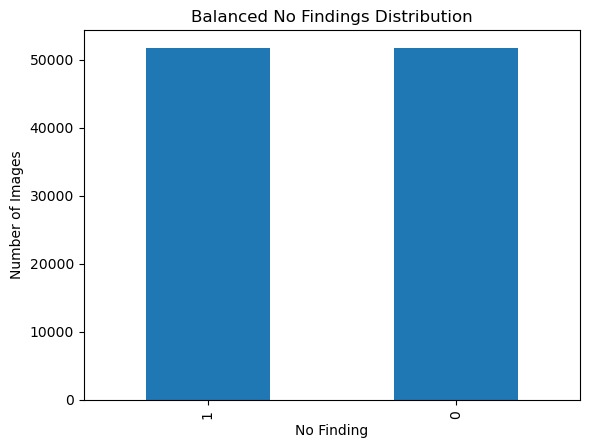

Epoch 1/10


c:\Users\abeli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2587/2587 ━━━━━━━━━━━━━━━━━━━━ 3762s 1s/step - accuracy: 0.5204 - loss: 0.7087 - val_accuracy: 0.5846 - val_loss: 0.6724
Epoch 2/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 3785s 1s/step - accuracy: 0.5771 - loss: 0.6774 - val_accuracy: 0.5823 - val_loss: 0.6717
Epoch 3/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 3791s 1s/step - accuracy: 0.5929 - loss: 0.6699 - val_accuracy: 0.6102 - val_loss: 0.6618
Epoch 4/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 3788s 1s/step - accuracy: 0.6015 - loss: 0.6669 - val_accuracy: 0.6049 - val_loss: 0.6630
Epoch 5/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 3805s 1s/step - accuracy: 0.6012 - loss: 0.6662 - val_accuracy: 0.6052 - val_loss: 0.6631
Epoch 6/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 3743s 1s/step - accuracy: 0.6002 - loss: 0.6663 - val_accuracy: 0.6132 - val_loss: 0.6604
Epoch 7/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 3815s 1s/step - accuracy: 0.6079 - loss: 0.6618 - val_accuracy: 0.6132 - val_loss: 0.6598
Epoch 8/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 3749s 1s/step - accuracy: 0.6115 - loss: 0.65

In [1]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import sklearn.utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:

# Load the data from the datasets
bbox_df = pd.read_csv('Resources/cleaned_bbox_data.csv')
data_df = pd.read_csv('Resources/cleaned_data_entry.csv')

# Images data path archive/images_001/ to archive/images_012/
image_folders = [f'archive/images_{i:03}/images' for i in range(1, 13)]

# Create a dataframe to store the image paths
image_paths = []
image_indices = []
for folder in image_folders:
    folder_path = os.path.join(folder)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, filename))
            image_indices.append(filename)


# Create a new dataframe with image paths and merge with the existing data
image_paths_df = pd.DataFrame({'Image Path': image_paths, 'Image Index': image_indices})

In [ ]:


# Ensure there are no duplicates in the index column
bbox_df = bbox_df.drop_duplicates(subset='Image Index')
data_df = data_df.drop_duplicates(subset='Image Index')

# Merge bbox_df and data_df with the image paths dataframe
merged_df = pd.merge(pd.merge(bbox_df, data_df, on='Image Index', how='outer'), image_paths_df, on='Image Index', how='inner')

# Display the first few rows of the merged dataframe to check the merge result
print("Merged DataFrame:")
print(merged_df.head())


In [ ]:

# Ensure merged_df is not empty before proceeding
if merged_df.empty:
    raise ValueError("The merged dataframe is empty. Check if the Image Index values match across all dataframes.")


In [ ]:

# Separate majority and minority classes
majority_class = data_df[data_df['No Finding'] == 1]
minority_classes = data_df[data_df['No Finding'] == 0]

# Undersample majority class
majority_undersampled = resample(majority_class, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(minority_classes),     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
balanced_data_df = pd.concat([majority_undersampled, minority_classes])

# Add Image Path column to balanced_data_df
balanced_data_df = pd.merge(balanced_data_df, image_paths_df, on='Image Index', how='inner')


In [ ]:

# Display the new class distribution
balanced_disease_counts = balanced_data_df['No Finding'].value_counts()
print("\nBalanced 'No Finding' distribution:")
print(balanced_disease_counts)

# Plot the balanced class distribution
balanced_disease_counts.plot(kind='bar')
plt.title('Balanced No Findings Distribution')
plt.xlabel('No Finding')
plt.ylabel('Number of Images')
plt.show()


In [ ]:

# Function to preprocess images (resize to desired dimensions)
def preprocess_image(img_path, target_size=(256, 256)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    # img = img.convert('RGB')  # Ensure all images are in RGB format
    img = np.array(img)
    return img / 255.0  # Normalize to range [0, 1]


In [ ]:

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Custom generator to yield batches of images and labels
class AugmentedDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.data_gen = data_gen

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = np.array([preprocess_image(path, self.target_size) for path in batch_image_paths])
        augmented_images = np.array([self.data_gen.random_transform(img) for img in images])
        return augmented_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            self.image_paths, self.labels = sklearn.utils.shuffle(self.image_paths, self.labels)


In [ ]:

# Split the data into training and testing sets
train_df, test_df = train_test_split(balanced_data_df, test_size=0.2, random_state=42)

# Prepare data for generators
train_images_paths = train_df['Image Path'].values
test_images_paths = test_df['Image Path'].values
train_labels_detection = train_df['No Finding'].to_numpy()
test_labels_detection = test_df['No Finding'].to_numpy()

# Create augmented data generators
train_generator = AugmentedDataGenerator(train_images_paths, train_labels_detection, batch_size=32)
test_generator = AugmentedDataGenerator(test_images_paths, test_labels_detection, batch_size=32)


In [ ]:

# Adjust the learning rate
optimizer = Adam(learning_rate=0.001)

# Define the CNN model for 'No Finding' detection
def create_detection_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(15, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the detection model
detection_model = create_detection_model((256, 256, 1))
detection_model.fit(train_generator, epochs=10, validation_data=test_generator)

# Save the detection model
# detection_model.save('detection_model.h5')



In [2]:
# Save the detection model in the recommended Keras format
detection_model.save('detection_model.keras')


647/647 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.5026 - loss: 0.6963
Test Accuracy: 0.5023
Test Loss: 0.6965
647/647 ━━━━━━━━━━━━━━━━━━━━ 646s 999ms/step

Classification Report:
              precision    recall  f1-score   support

  No Finding       0.00      0.00      0.00     10304
     Finding       0.50      1.00      0.67     10400

    accuracy                           0.50     20704
   macro avg       0.25      0.50      0.33     20704
weighted avg       0.25      0.50      0.34     20704



c:\Users\abeli\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abeli\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abeli\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


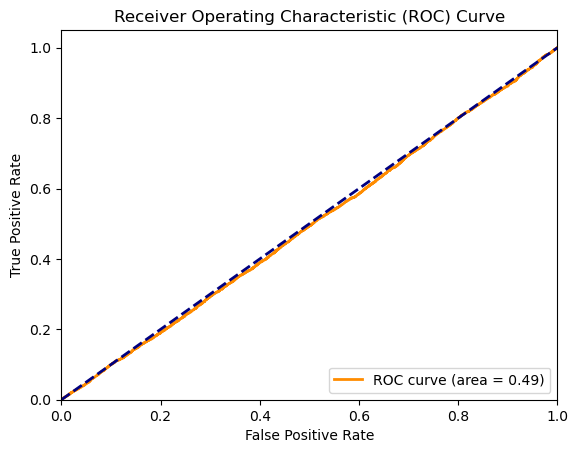

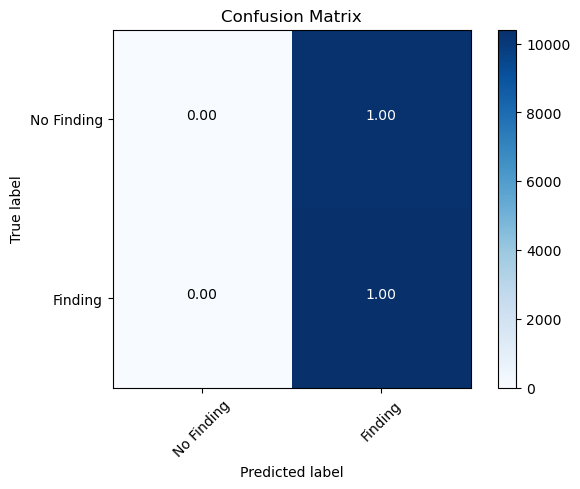

In [6]:
# Evaluate the model on the test set
test_loss, test_accuracy = detection_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predict the probabilities on the test set
test_predictions = detection_model.predict(test_generator)
test_predictions_classes = (test_predictions > 0.5).astype("int32")

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("\nClassification Report:")
print(classification_report(test_labels_detection, test_predictions_classes, target_names=['No Finding', 'Finding']))

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_labels_detection, test_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels_detection, test_predictions_classes)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Finding', 'Finding'], rotation=45)
plt.yticks(tick_marks, ['No Finding', 'Finding'])

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Add text annotations
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, f"{conf_matrix[i, j]:.2f}", horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
